In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines       import Line2D
from os.path                import join
import random
from re                     import split
import torch                
import torch.nn             as nn
import torch.optim          as optim
from torch.utils.data       import DataLoader
from torchvision.datasets   import MNIST
import torchvision.transforms as transforms
import torchvision.utils    as vutils

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


when generator loss goes up
1. add gaussian noise to input image
2. label smoothing
3. add dropout layers

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
torch.mps.empty_cache()
latent_size = 64 
hidden_size = 256 
image_size = 784 
num_epochs = 5
lr = 0.0002
IMAGE_CHANNEL = 1
G_HIDDEN = 64
D_HIDDEN = 64
Z_DIM = 100
batch_size= 128

In [4]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [5]:
device           = torch.device("mps")

dataset  = MNIST(root="~/torch_datasets",
                          train     = True,
                          transform = transforms.Compose([transforms.Resize(32),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize((0.5,), (0.5,))]),
                                                          #AddGaussianNoise(0., 0.1)]),
                          download  = True)
dataloader   = DataLoader(dataset,
                               batch_size  = batch_size,
                               shuffle     = True)
                               #num_workers = 2)

In [6]:
batch_features, _ = next(iter(dataloader))

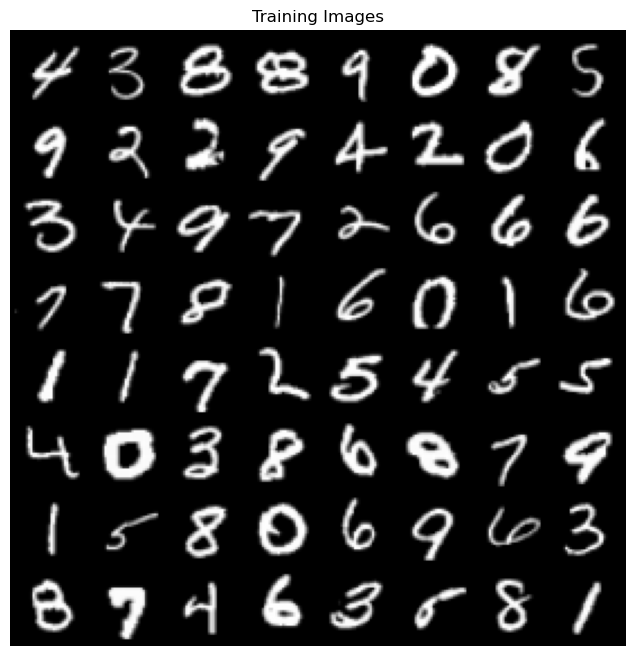

In [7]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch_features[:64].to('cpu'), padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [8]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the generator
netG = Generator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)
# Print the model
#print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [10]:
class Discriminator(nn.Module):
   def __init__(self):
       super().__init__()
       self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            # output layer
            nn.Conv2d(D_HIDDEN * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

   def forward(self, x):
       return self.main(x).view(-1, 1).squeeze(1)
    
# Create the generator
netD = Discriminator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netD.apply(weights_init)

# Print the model
#print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, Z_DIM, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake[:64], padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/5][0/469]	Loss_D: 2.2704	Loss_G: 0.9449	D(x): 0.5105	D(G(z)): 0.6651 / 0.4653
[0/5][10/469]	Loss_D: 0.6846	Loss_G: 2.1371	D(x): 0.8050	D(G(z)): 0.3000 / 0.1739
[0/5][20/469]	Loss_D: 1.0101	Loss_G: 2.4267	D(x): 0.6626	D(G(z)): 0.2922 / 0.1455
[0/5][30/469]	Loss_D: 1.0776	Loss_G: 2.6880	D(x): 0.6633	D(G(z)): 0.3081 / 0.1244
[0/5][40/469]	Loss_D: 0.8871	Loss_G: 3.0233	D(x): 0.6912	D(G(z)): 0.2632 / 0.1033
[0/5][50/469]	Loss_D: 0.9849	Loss_G: 2.9815	D(x): 0.6743	D(G(z)): 0.2655 / 0.0902
[0/5][60/469]	Loss_D: 0.9033	Loss_G: 2.6232	D(x): 0.7323	D(G(z)): 0.3023 / 0.1298
[0/5][70/469]	Loss_D: 0.5081	Loss_G: 3.0735	D(x): 0.7759	D(G(z)): 0.1215 / 0.0976
[0/5][80/469]	Loss_D: 0.6631	Loss_G: 2.8284	D(x): 0.7215	D(G(z)): 0.1463 / 0.1291
[0/5][90/469]	Loss_D: 0.8423	Loss_G: 3.4917	D(x): 0.7913	D(G(z)): 0.3266 / 0.0715
[0/5][100/469]	Loss_D: 0.6617	Loss_G: 3.5553	D(x): 0.7187	D(G(z)): 0.1391 / 0.0611
[0/5][110/469]	Loss_D: 0.6392	Loss_G: 3.3879	D(x): 0.7657	D(G(z)): 0.183

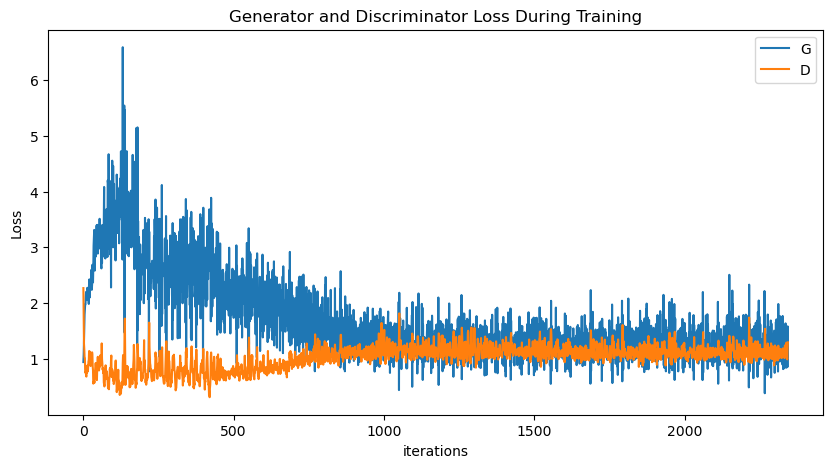

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
print(len(img_list))

48


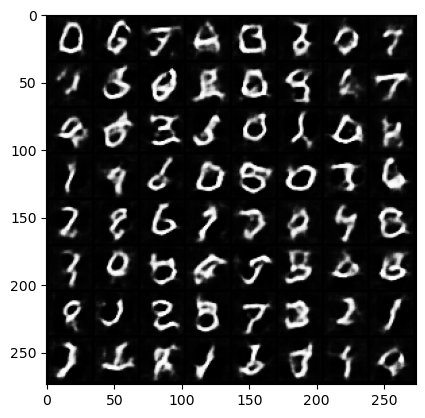

In [17]:
plt.imshow(np.transpose(vutils.make_grid(img_list[24][:64].to('cpu'), padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

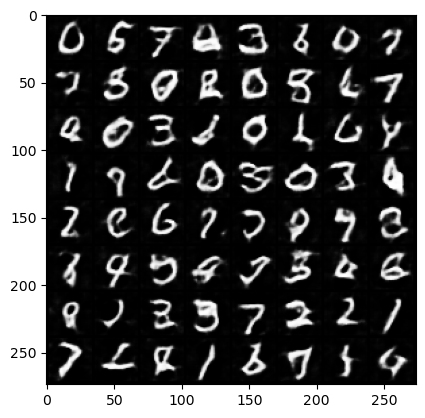

In [15]:
plt.imshow(np.transpose(vutils.make_grid(img_list[-1][:64].to('cpu'), padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')